In [1]:
import sys

sys.path.append('..')
from src.tools.experiments import print_env, set_seed
print_env()
set_seed(42)

========== System Information ==========
DATE : 2023-09-04
Pyton Version : 3.8.17
PyTorch Version : 1.13.0
OS : Linux 5.4.0-155-generic
CPU spec : x86_64
RAM spec : 503.73 GB
Device 0:
Name: NVIDIA A100-SXM4-40GB
Total Memory: 40536.1875 MB
Driver Version: 470.199.02
Device 1:
Name: NVIDIA A100-SXM4-40GB
Total Memory: 40536.1875 MB
Driver Version: 470.199.02
Device 2:
Name: NVIDIA A100-SXM4-40GB
Total Memory: 40536.1875 MB
Driver Version: 470.199.02
Device 3:
Name: NVIDIA DGX Display
Total Memory: 3911.875 MB
Driver Version: 470.199.02
Device 4:
Name: NVIDIA A100-SXM4-40GB
Total Memory: 40536.1875 MB
Driver Version: 470.199.02


In [2]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from src.tools.rle_encoder import rle_encode
from src.data.dataset import SourceDataset, TargetDataset
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [38]:
import torch
import albumentations as A

from src.data.fisheye_transform import FisheyeTransform

augmentation = A.Compose([
    FisheyeTransform(p=0.5),
    #A.RandomCrop(width=224, height=224),
    A.RandomScale(scale_limit=0.2, p=0.2),
    #A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    A.ColorJitter(p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    #A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet 데이터의 통계량으로 정규화
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)

In [39]:
from src.data.dataset import SourceDataset, TargetDataset

train_dataset = SourceDataset(csv_file='train_source.csv', transform=augmentation, is_training=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

valid_dataset = SourceDataset(csv_file='val_source.csv', transform=transform, is_training=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [30]:
# DeepLabV3 with ResNet101 backbone:
from src.model.pretrained import DeepLabV3

model = DeepLabV3(backbone='mobilenet', pretrained=True, mode='all' )

model.to(device)

DeepLabV3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormAc

In [31]:
def save_checkpoint(model, optimizer, scheduler, epoch, filename='checkpoint.pth'):
    """
    모델의 체크포인트를 저장하는 함수.
    
    Parameters:
    - model (torch.nn.Module): 저장할 모델.
    - optimizer (torch.optim.Optimizer): 사용 중인 optimizer.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): 사용 중인 learning rate scheduler.
    - epoch (int): 현재 epoch.
    - filename (str): 저장할 체크포인트 파일의 이름.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}.")

def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pth'):
    """
    체크포인트를 로드하여 모델, optimizer, scheduler에 적용하는 함수.
    
    Parameters:
    - model (torch.nn.Module): 체크포인트를 로드할 모델.
    - optimizer (torch.optim.Optimizer): 체크포인트를 로드할 optimizer.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): 체크포인트를 로드할 scheduler.
    - filename (str): 로드할 체크포인트 파일의 이름.
    
    Returns:
    - epoch (int): 체크포인트의 epoch.
    - best_mIoU (float): 체크포인트의 최고 mIoU.
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print(f"Checkpoint loaded from {filename}.")
    return checkpoint['epoch'], checkpoint['best_mIoU']


In [32]:
class EarlyStopping:
    def __init__(self, patience, save_path, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, score, model, optimizer, scheduler, epoch):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model, optimizer, scheduler, epoch)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score, model, optimizer, scheduler, epoch)
            self.counter = 0

    def save_checkpoint(self, score, model, optimizer, scheduler, epoch):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_score': score
        }, self.save_path)
        if self.verbose:
            print(f"Validation score improved ({self.best_score:.6f} --> {score:.6f}). Saving model!")

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches


# Class names and colors
class_names = [
    "Road", "Sidewalk", "Construction", "Fence", "Pole",
    "Traffic Light", "Traffic Sign", "Nature", "Sky", 
    "Person", "Rider", "Car", "Background"
]

# Use the same colors for consistency
colors = [
    [1, 0, 0],        # Red
    [0, 1, 0],        # Green
    [0, 0, 1],        # Blue
    [1, 1, 0],        # Yellow
    [1, 0, 1],        # Magenta
    [0, 1, 1],        # Cyan
    [1, 0.5, 0],      # Orange
    [0.5, 0, 1],      # Purple
    [0.5, 1, 0],      # Lime
    [1, 0.5, 1],      # Pink
    [0, 1, 0.5],      # Teal
    [0.5, 0.5, 1],    # Lavender
    [0.6, 0.3, 0.1]   # Brown
]
def visualize_sample(image, ground_truth, prediction):
    """
    Visualize a sample along with ground truth and prediction.
    """
    # Convert tensors to numpy arrays for visualization
    image = image.permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)
    ground_truth = ground_truth.numpy()
    prediction = prediction.numpy()

    # Create masks for ground truth and prediction
    gt_mask = np.zeros((*ground_truth.shape, 3))
    pred_mask = np.zeros((*prediction.shape, 3))

    for idx, color in enumerate(colors):
        gt_mask[ground_truth == idx] = color
        pred_mask[prediction == idx] = color

    overlap = 0.5 * image + 0.5 * gt_mask
    overlap_with_pred = 0.5 * image + 0.5 * pred_mask

    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(overlap)
    ax[1].set_title("Ground Truth")
    ax[2].imshow(overlap_with_pred)
    ax[2].set_title("Prediction")
    ax[3].imshow(pred_mask)
    ax[3].set_title("Prediction Mask")

    # Create legend
    patches = [mpatches.Patch(color=np.array(color), label=class_name) for color, class_name in zip(colors, class_names)]
    ax[3].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    for a in ax:
        a.axis("off")

    plt.tight_layout()
    plt.show()

def visualize_random_sample(dataset, model, device):
    """
    Visualize a random sample from the given dataset.
    """
    random_sample_idx = np.random.randint(len(dataset))
    image, ground_truth = dataset[random_sample_idx]
    
    image = image.unsqueeze(0).to(device)
    model_output = model(image)
    _, prediction = model_output['out'].max(1)
    prediction = prediction[0].cpu()
    
    visualize_sample(image[0].cpu(), ground_truth, prediction)

Using only 1 GPU!


100%|██████████| 69/69 [04:05<00:00,  3.56s/it]


Epoch 1 - Training Loss: 32.4562, Training mIoU: 0.3199
Checkpoint saved to checkpoint.pth.
Visualizing random training sample...


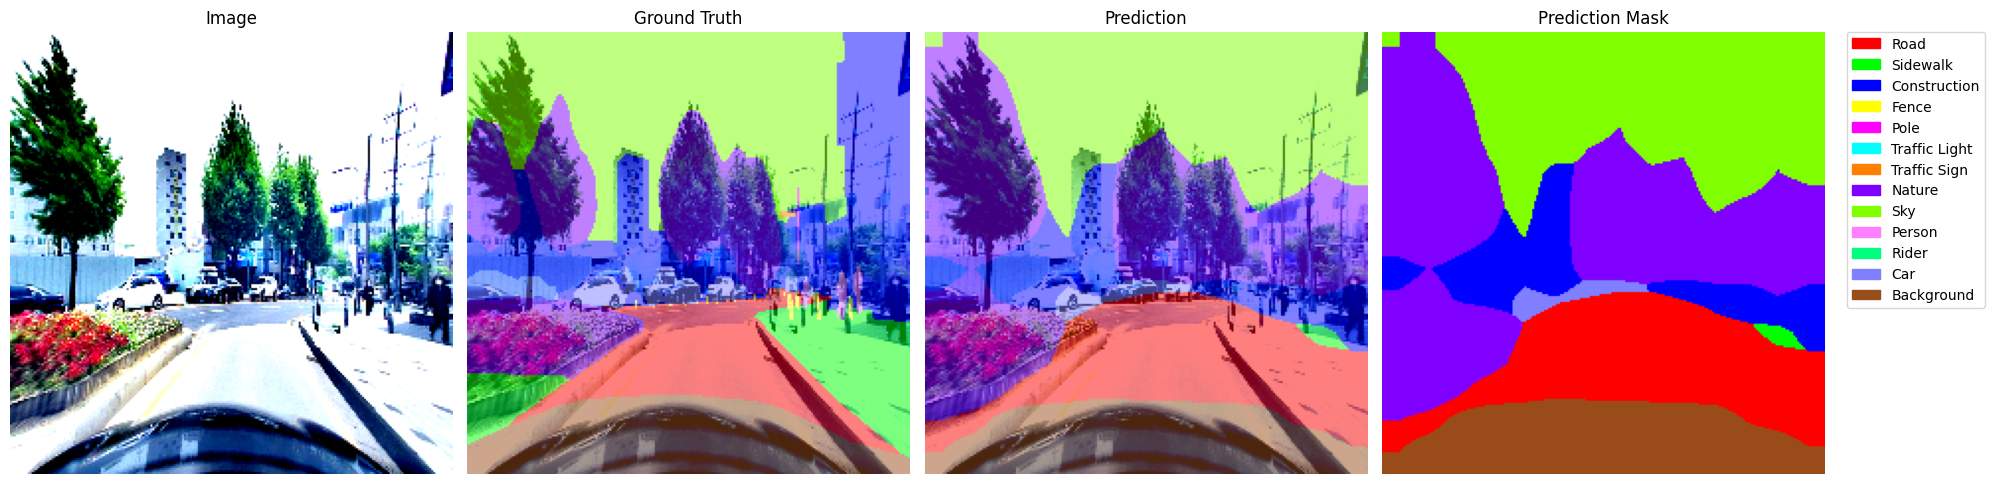

100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Epoch 1, mIoU: 0.3834
Visualizing random validation sample...


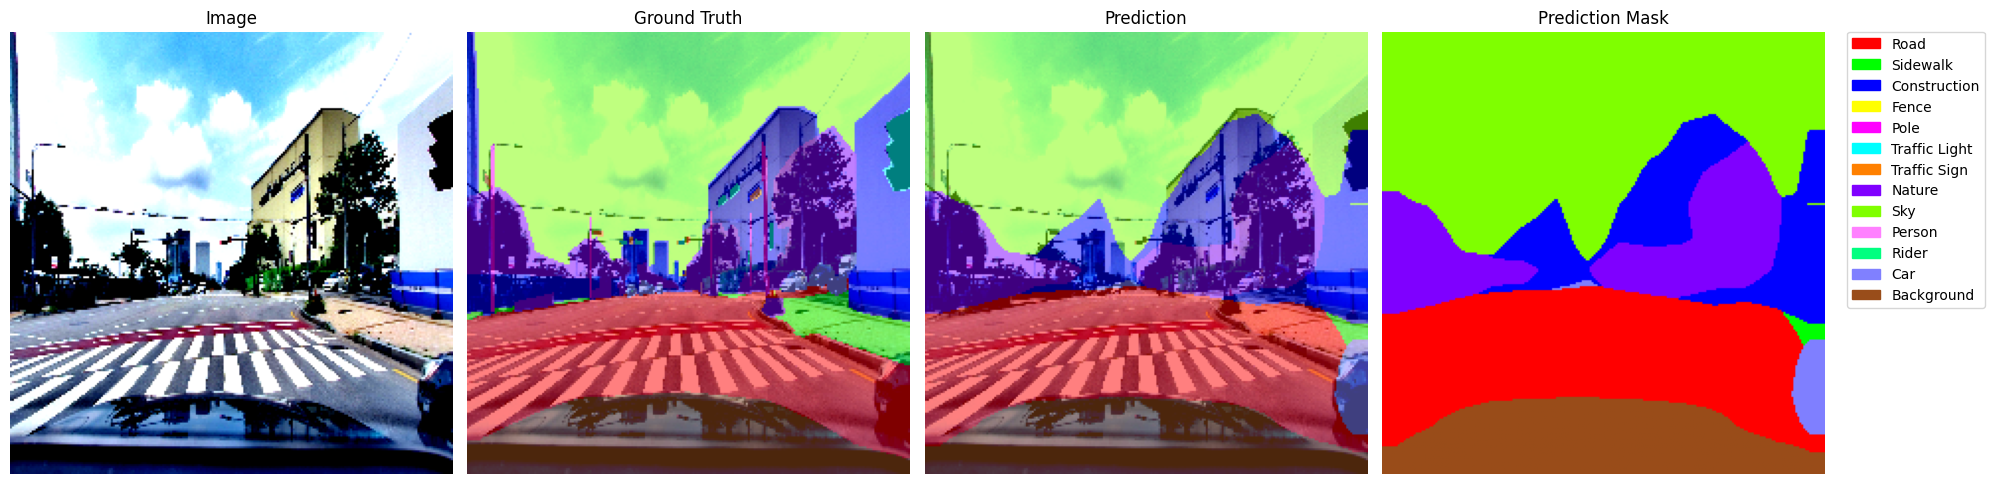

/home/shlee/venvs/vision_task/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:1679: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation score improved (0.383392 --> 0.383392). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.70it/s]


Validation score improved (0.404555 --> 0.404555). Saving model!


100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


Validation score improved (0.412540 --> 0.412540). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


Validation score improved (0.426906 --> 0.426906). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


EarlyStopping counter: 1 out of 50


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


EarlyStopping counter: 2 out of 50


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Validation score improved (0.427278 --> 0.427278). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Validation score improved (0.428712 --> 0.428712). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


Validation score improved (0.436763 --> 0.436763). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Validation score improved (0.438968 --> 0.438968). Saving model!


100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


EarlyStopping counter: 1 out of 50


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


EarlyStopping counter: 2 out of 50


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Validation score improved (0.440397 --> 0.440397). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


EarlyStopping counter: 1 out of 50


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


EarlyStopping counter: 2 out of 50


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Validation score improved (0.440582 --> 0.440582). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


EarlyStopping counter: 1 out of 50


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Validation score improved (0.441374 --> 0.441374). Saving model!


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


EarlyStopping counter: 1 out of 50


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


EarlyStopping counter: 2 out of 50


 64%|██████▍   | 44/69 [02:44<00:53,  2.14s/it]

In [42]:
import datetime
import os
from torch.utils.tensorboard import SummaryWriter  # TensorBoard의 SummaryWriter를 임포트합니다.

from torch.optim.lr_scheduler import OneCycleLR
from src.tools.metrics import compute_mIoU

# 1. 모델 불러오기
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    multi_gpu_train = True
elif torch.cuda.device_count() == 1:
    print(f"Using only 1 GPU!")
    model.to(device)
    multi_gpu_train = False
else:
    print(f"Using CPU")
    model.to(device)
    multi_gpu_train = False

# 2. 데이터 준비 (여기서는 간략하게 표현합니다)
#train_loader, val_loader = prepare_target_domain_dataloaders()

# 3. 학습 설정
criterion = nn.CrossEntropyLoss() # 예시로 CrossEntropyLoss를 사용합니다
LEARNING_RATE = 1e-5

# Optimizer 설정 시, requires_grad=True로 설정된 파라미터만 포함시킵니다.
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)




# 4. 학습
num_epochs = 20000
train_losses = []
train_mIoUs = []
val_mIoUs = []

# 보조 출력에 대한 손실 가중치
aux_loss_weight = 0.3


# Directory for saving checkpoints based on the time when the training started
model_name = type(model).__name__
start_time = datetime.datetime.now().strftime('%y%m%d_%H%M')
checkpoint_dir = os.path.join(start_time + '_' + model_name)
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{start_time}.pth")

# Early stopping 관련 설정
patience = 50
early_stopping = EarlyStopping(patience=patience, save_path=checkpoint_path, verbose=True)

# Learning rate scheduler 설정

# OneCycleLR 설정
steps_per_epoch = len(train_loader)  # 한 에폭당 스텝 수
scheduler = OneCycleLR(optimizer, max_lr=1e-2, epochs=num_epochs, 
                       steps_per_epoch=steps_per_epoch, 
                       div_factor=25, pct_start=0.3, anneal_strategy='cos')



# TensorBoard SummaryWriter 초기화
writer = SummaryWriter('runs/'+checkpoint_dir)



for epoch in range(num_epochs):
    model.train()
    model.freeze_bn()
    total_loss = 0.0
    total_iou = 0.0
    num_batches = 0
    num_images = 0
    
    for images, masks in tqdm(train_loader):
        
        images = images.float().to(device)
        masks = masks.long().to(device)
        num_images += images.size(0)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # 주 출력에 대한 손실 계산
        main_loss = criterion(outputs['out'], masks)
        
        # 보조 출력에 대한 손실 계산
        aux_loss = criterion(outputs['aux'], masks)
        
        # 두 손실을 결합
        loss = main_loss + aux_loss_weight * aux_loss
        
        loss.backward()
        # loss = criterion(outputs, masks)
        # loss.backward()
        optimizer.step()
        
        total_loss += num_images * loss.item()
        _, predicted = outputs['out'].max(1)
        
        # 배치 내에 있는 샘플들에 대해 mIoU를 계산
        batch_iou = 0.0
        batch_iou = sum(compute_mIoU(pred, gt) for pred, gt in zip(predicted, masks))
            
        total_iou += batch_iou
        num_batches += 1
        
    avg_loss = total_loss / num_images
    avg_train_mIoU = total_iou / num_images
    train_losses.append(avg_loss)
    train_mIoUs.append(avg_train_mIoU)
    
    # TensorBoard에 학습 손실 및 mIoU 로깅
    writer.add_scalar('Training Loss', avg_loss, epoch)
    writer.add_scalar('Training mIoU', avg_train_mIoU, epoch)
    
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}, Training mIoU: {avg_train_mIoU:.4f}")
        save_checkpoint(model, optimizer, scheduler, checkpoint_path)
        # For Training data
        print("Visualizing random training sample...")
        visualize_random_sample(train_dataset, model, device)
    
        
    # 5. 검증 (간략하게 표현)
    with torch.no_grad():
        model.eval()
        total_iou = 0
        num_images = 0
        for images, masks in tqdm(valid_loader):
            images = images.float().to(device)
            masks = masks.long().to(device)
        
            outputs = model(images)
            _, predicted = outputs['out'].max(1)
            
            # 배치 내에 있는 샘플들에 대해 mIoU를 계산
            batch_iou = sum(compute_mIoU(pred, gt) for pred, gt in zip(predicted, masks))
            total_iou += batch_iou
            num_images += images.size(0)
        avg_mIoU = total_iou / num_images
        
        # TensorBoard에 검증 mIoU 로깅
        writer.add_scalar('Validation mIoU', avg_mIoU, epoch)

        if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}, mIoU: {avg_mIoU:.4f}")
            print("Visualizing random validation sample...")
            visualize_random_sample(valid_dataset, model, device)


    # 학습률 업데이트 및 로깅
    scheduler.step()
    writer.add_scalar('Learning Rate', scheduler.get_lr()[0], epoch)  # 현재 학습률을 로깅합니다.

    
    # Early stopping 검사
    early_stopping(avg_mIoU, model, optimizer, scheduler, epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.3445150421725379


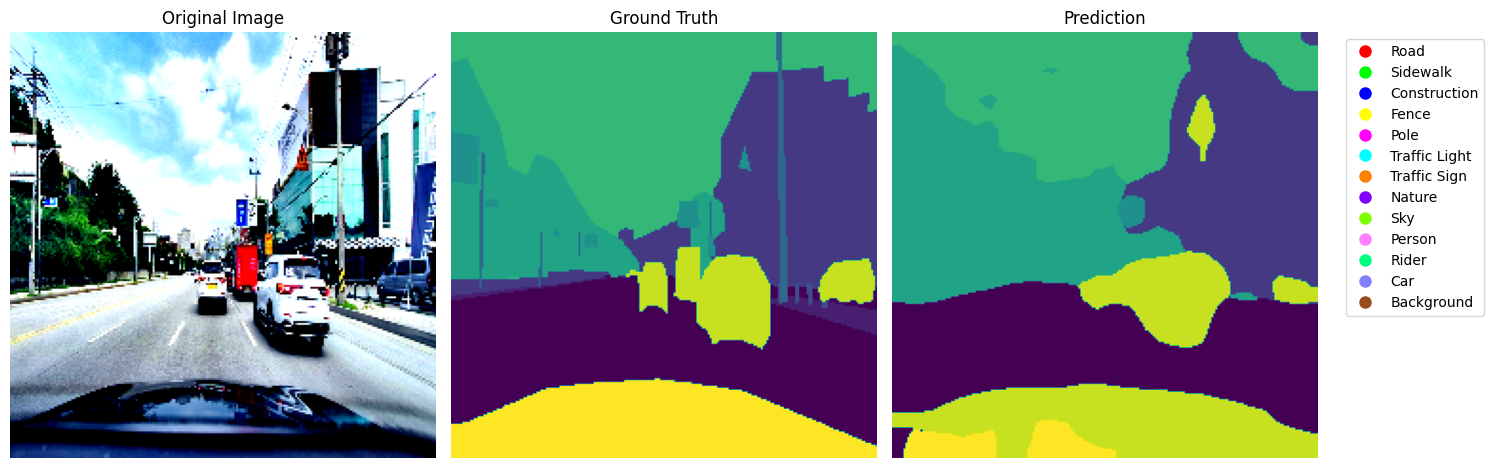

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_segmentation_comparison(input_image, ground_truth, prediction, class_names, colors):
    """
    Visualize segmentation results with ground truth and predictions side by side.
    
    Args:
    - input_image (torch.Tensor): the original image of shape (3, H, W)
    - ground_truth (torch.Tensor): the ground truth labels of shape (num_classes, H, W)
    - prediction (torch.Tensor): the model's predictions of shape (num_classes, H, W)
    - class_names (list): a list of class names
    - colors (list): a list of colors for each class
    
    Returns:
    - A matplotlib plot
    """
    
    # Convert PyTorch tensors to numpy arrays
    input_image_np = input_image.permute(1, 2, 0).cpu().detach().numpy()
    ground_truth_np = ground_truth.cpu().detach().numpy()
    prediction_np = prediction.cpu().detach().numpy()
    
    # Determine the predicted class labels
    gt_labels = np.argmax(ground_truth_np, axis=0)
    pred_labels = np.argmax(prediction_np, axis=0)
    
    # Convert the labeled images to RGB images
    #gt_rgb = np.zeros((*gt_labels.shape, 3), dtype=np.uint8)
    #pred_rgb = np.zeros((*pred_labels.shape, 3), dtype=np.uint8)
    
    #for idx, color in enumerate(colors):
        #gt_rgb[gt_labels == idx, :] = color
        #pred_rgb[pred_labels == idx, :] = color

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(input_image_np)
    ax[0].set_title("Original Image")
    
    ax[1].imshow(ground_truth)
    ax[1].set_title("Ground Truth")
    
    ax[2].imshow(pred_image)
    ax[2].set_title("Prediction")
    
    # Legend
    patches = [plt.Line2D([0], [0], marker='o', color='w', label=class_names[i], markersize=10, markerfacecolor=colors[i]) for i in range(len(colors))]
    ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for a in ax:
        a.axis("off")
    
    plt.tight_layout()
    plt.show()


# Class names and colors
class_names = [
    "Road", "Sidewalk", "Construction", "Fence", "Pole",
    "Traffic Light", "Traffic Sign", "Nature", "Sky", 
    "Person", "Rider", "Car", "Background"
]

# Use the same colors for consistency
colors = [
    [1, 0, 0],        # Red
    [0, 1, 0],        # Green
    [0, 0, 1],        # Blue
    [1, 1, 0],        # Yellow
    [1, 0, 1],        # Magenta
    [0, 1, 1],        # Cyan
    [1, 0.5, 0],      # Orange
    [0.5, 0, 1],      # Purple
    [0.5, 1, 0],      # Lime
    [1, 0.5, 1],      # Pink
    [0, 1, 0.5],      # Teal
    [0.5, 0.5, 1],    # Lavender
    [0.6, 0.3, 0.1]   # Brown
]

item = 1
model.eval()
valid_image, ground_truth = valid_dataset.__getitem__(item)
_, pred_image = model(valid_image.unsqueeze(0).to(device))['out'].max(1)
pred_image = pred_image.cpu()[0]
# Example usage:
# Assuming input_image, ground_truth, and prediction tensors are available
print(compute_mIoU(pred_image, ground_truth))
visualize_segmentation_comparison(valid_image, ground_truth, pred_image[0], class_names, colors)


In [15]:
test_dataset = TargetDataset(csv_file='./test.csv', transform=transform, is_training=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [16]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)['out']
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

100%|██████████| 119/119 [00:58<00:00,  2.03it/s]


In [17]:
submit = pd.read_csv('../data/raw/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,-1
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,1 141 875 227 1835 227 2795 227 3755 227 4715 ...
3,TEST_0000_class_3,-1
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,-1
22772,TEST_1897_class_8,322 296 1282 296 2242 296 3202 296 4162 296 51...
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [18]:
submit.to_csv('./[23.09.03]deeplabv3_mobilenet.csv', index=False)

In [19]:
def save_checkpoint(model, optimizer, loss, epoch, hyperparameters, filename='model_checkpoint.pth'):
    """
    모델과 학습 관련 정보들을 저장하는 함수
    
    Args:
    - model (torch.nn.Module): 학습된 모델
    - optimizer (torch.optim.Optimizer): 사용된 optimizer
    - loss (float): 마지막으로 기록된 loss 값
    - epoch (int): 학습 중단 시점의 epoch
    - hyperparameters (dict): 학습에 사용된 하이퍼파라미터들 (e.g., learning_rate, batch_size)
    - filename (str): 저장될 파일의 이름 (기본값: 'model_checkpoint.pth')
    
    Returns:
    - None
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'hyperparameters': hyperparameters
    }
    
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

# 사용 예시
save_checkpoint(model, optimizer, loss, epoch, {'learning_rate': 0.001, 'batch_size': 32}, filename='(ckpt)[23.09.02]lraspp_mobilenet.pth')

Checkpoint saved to (ckpt)[23.09.02]lraspp_mobilenet.pth
